# Homework 4 - Applied ML

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### Answer

We start by loading the data and reformat it to ease our following work.
For instance, the race is splitted in several columns, so we put that information back in one single column.
Some data can be converted to booleans, also `nodegree` is negative so we compute its inverse `degree` to simplify.

In [2]:
lalonde = pd.read_csv('lalonde.csv', index_col = 'id')

# Label races
races = ['White', 'Black', 'Hispanic']
lalonde['race_id'] = [l[1].black + 2 * l[1].hispan for l in lalonde.iterrows()]
lalonde['race_id'] = lalonde['race_id'].astype('int')
lalonde['race'] = lalonde['race_id'].apply(lambda rid: races[rid])
lalonde['race'] = lalonde['race'].astype('category', ordered = True)

# Convert to booleans
lalonde.treat = lalonde.treat.astype('bool')
lalonde.married = lalonde.married.astype('bool')
lalonde['degree'] = (1 - lalonde.nodegree).astype('bool')

# Filter columns
lalonde = lalonde[['treat', 'age', 'educ', 'race_id', 'race', 'married', 'degree', 're74', 're75', 're78']]
lalonde

,treat,age,educ,race_id,race,married,degree,re74,re75,re78
id,,,,,,,,,,
NSW1,True,37,11,1,Black,True,False,0.0,0.0,9930.0460
NSW2,True,22,9,2,Hispanic,False,False,0.0,0.0,3595.8940
NSW3,True,30,12,1,Black,False,True,0.0,0.0,24909.4500
NSW4,True,27,11,1,Black,False,False,0.0,0.0,7506.1460
NSW5,True,33,8,1,Black,False,False,0.0,0.0,289.7899
NSW6,True,22,9,1,Black,False,False,0.0,0.0,4056.4940
NSW7,True,23,12,1,Black,False,True,0.0,0.0,0.0000
NSW8,True,32,11,1,Black,False,False,0.0,0.0,8472.1580
NSW9,True,22,16,1,Black,False,True,0.0,0.0,2164.0220


Now we define a function to plot histogram of feature groupped by `treat`. This function manually compute the histogram to plot both the treated and control group on the same graph. The bins are also manually computed to ensure both histograms are based on the same scaling.

In [42]:
def hist_by_treat(lalonde, feature, bin_size):
    fserie = lalonde[feature]
    if fserie.dtype.name != 'category':
        lmin, lmax = bin_size * int(fserie.min() / bin_size), bin_size * (int(fserie.max() / bin_size) + 1)
        bins = np.arange(lmin, lmax, bin_size)
        hist_notreat = np.histogram(fserie[lalonde.treat == 0], bins = bins, range = [lmin, lmax])
        hist_treat = np.histogram(fserie[lalonde.treat == 1], bins = bins, range = [lmin, lmax])
        
        index = hist_notreat[1][1:]
        hist_notreat, hist_treat = hist_notreat[0], hist_treat[0]
    else:
        hist_notreat = fserie[lalonde.treat == 0].value_counts()
        hist_treat = fserie[lalonde.treat == 1].value_counts()
        index = fserie.cat.categories
    
    pd.DataFrame({
            'notreat': hist_notreat,
            'treat': hist_treat
        },
        columns = ['notreat', 'treat'],
        index = index
    ).plot.bar(figsize = (12, 6), width = .9)

We can finally get the distribution of earnings in 1978 by `treat`!

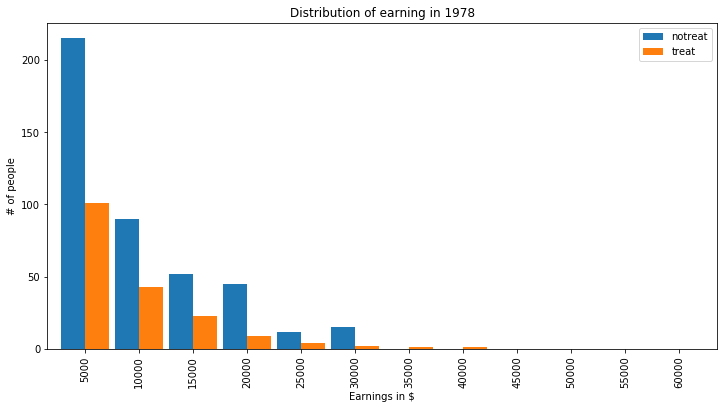

In [41]:
hist_by_treat(lalonde, 're78', 5000)
plt.title('Distribution of earning in 1978')
plt.xlabel('Earnings in $')
plt.ylabel('# of people')

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Answer

We can use our previous function to plot the distribution of the other features. We just need to manually define the size on the bins for each features. Those size have been choosed to give meaningfull representation for their associated feature.

We notice the following discrepancies:
  * The _age_ distribution of the treated group doesn't follow the _age_ distribution of the control group.
  * The distribution of "years of education" (_educ_) has a spike at 13 years for the control group that doesn't exist for the treated group.
  * The majority of treated people are black, while the majority of the control group are white (_race_).
  * The _married_ distribution differ between the treated group and the control group.
  
Since the distribution of people does not match between the two groups, we can't draw a conclusion as simply as we did in the previous part. The groups seem to represent different social categories, so the data shows more the inequalities between those categories than the efficiency of the training program.

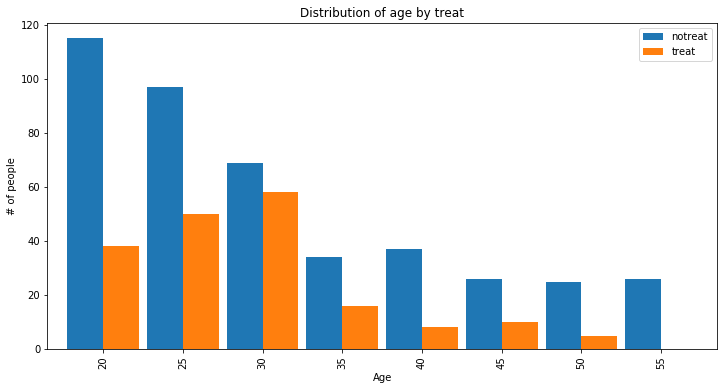

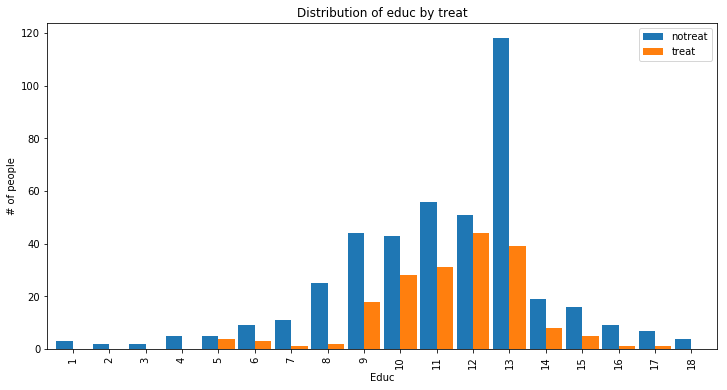

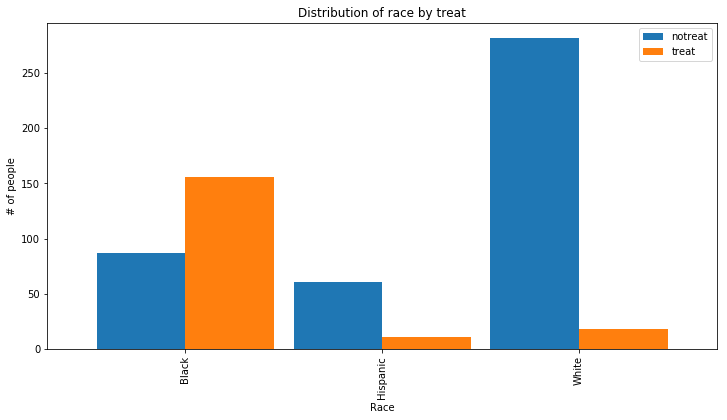

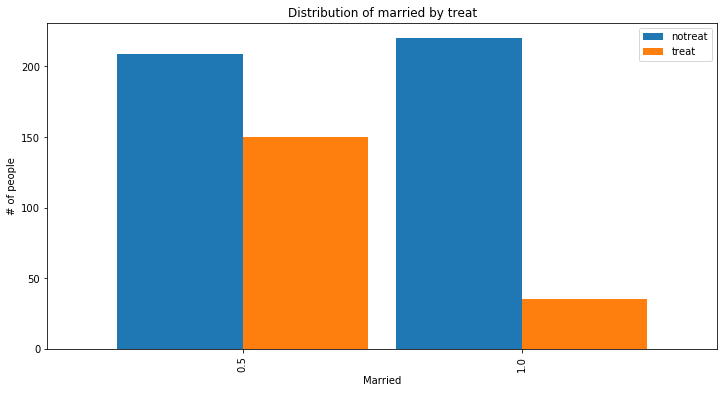

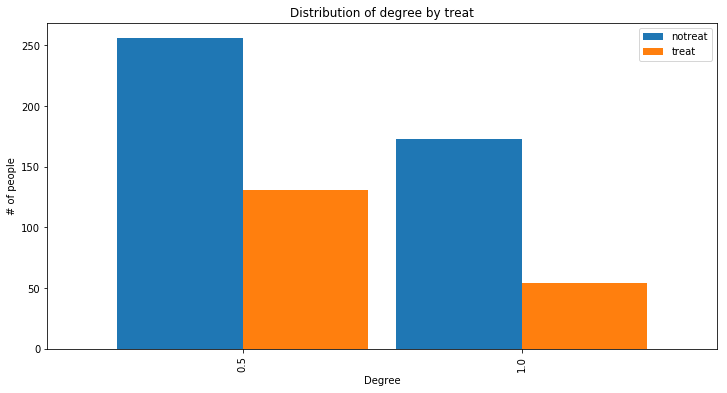

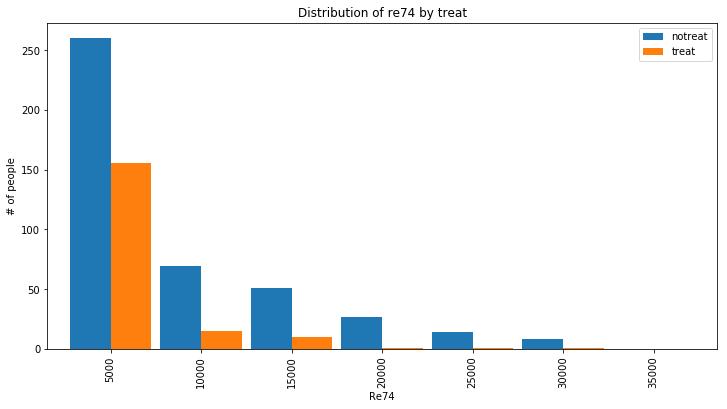

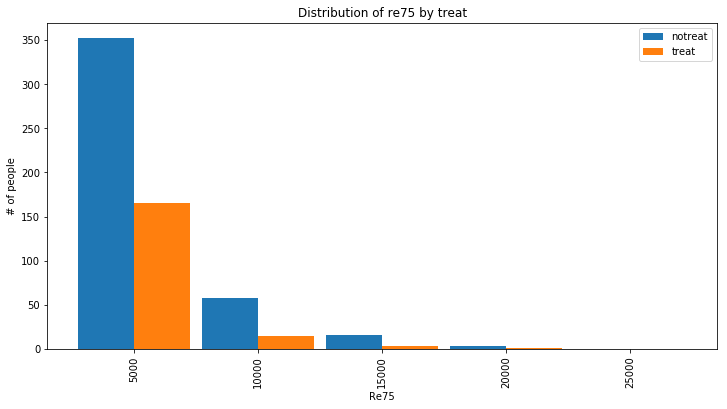

In [43]:
bin_sizes = { 'age': 5, 'educ': 1, 'race': 0.667, 'married': 0.5, 'degree': 0.5, 're74': 5000, 're75': 5000 }

for feature in bin_sizes.keys():
    hist_by_treat(lalonde, feature, bin_sizes[feature])
    plt.title('Distribution of {} by treat'.format(feature))
    plt.xlabel(feature.capitalize())
    plt.ylabel('# of people')

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. It's sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### Answer

Not much to explain here. We select the pre-treatment features and fit a model using them and the `treat` feature. We use `predict_proba` to get continuous propensity scores and not just `True` or `False`.

In [6]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()

X = lalonde[['age', 'educ', 'race_id', 'married', 'degree', 're74', 're75']]
Y = lalonde['treat'].astype('float64')

logistic.fit(X, Y)

lalonde['propensity'] = logistic.predict_proba(X)[:,1]
lalonde

,treat,age,educ,race_id,race,married,degree,re74,re75,re78,propensity
id,,,,,,,,,,,
NSW1,True,37,11,1,Black,True,False,0.0,0.0,9930.0460,0.254952
NSW2,True,22,9,2,Hispanic,False,False,0.0,0.0,3595.8940,0.684056
NSW3,True,30,12,1,Black,False,True,0.0,0.0,24909.4500,0.483891
NSW4,True,27,11,1,Black,False,False,0.0,0.0,7506.1460,0.520852
NSW5,True,33,8,1,Black,False,False,0.0,0.0,289.7899,0.522430
NSW6,True,22,9,1,Black,False,False,0.0,0.0,4056.4940,0.519274
NSW7,True,23,12,1,Black,False,True,0.0,0.0,0.0000,0.481845
NSW8,True,32,11,1,Black,False,False,0.0,0.0,8472.1580,0.522312
NSW9,True,22,16,1,Black,False,True,0.0,0.0,2164.0220,0.481786



#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

#### Answer

We create a bipartite graph, using the library **networkx**, with weighted edges. The library provides a function to match pair of nodes while maximizing the weight of the edge, but we want to minimize the difference. To solve this issue, we simply take the oposite of the absolute value of the difference, thus the bigger weight are the one with the smallest difference. We also need to set `maxcardinality = True` for the function `max_weight_matching` to get the maximum amount of matches, it only compute a small subset if the value is `False`.

**Note**: computing the max matching can take a moment, please be patient!

Once the pairs are computed, we store the balanced dataset in `balanced_lalonde`.

In [7]:
import networkx as nx

treat_group = lalonde[lalonde.treat == True]
control_group = lalonde[lalonde.treat == False]

print("Add nodes to graph...")
G = nx.Graph()
G.add_nodes_from(treat_group.index, bipartite = 1)
G.add_nodes_from(control_group.index, bipartite = 0)

print("Add edges to graph...")
for treat_idx, treat in treat_group.iterrows():
    for control_idx, control in control_group.iterrows():
        G.add_edge(treat_idx, control_idx, weight = -abs(treat.propensity - control.propensity))

print("Match nodes...")
matches = nx.matching.max_weight_matching(G, maxcardinality = True)

print("Building balanced groups...")
balanced_treat_group = treat_group.loc[matches.keys()].dropna()
balanced_control_group = control_group.loc[matches.keys()].dropna()
balanced_lalonde = balanced_treat_group.append(balanced_control_group)

Add nodes to graph...
Add edges to graph...
Match nodes...
Building balanced groups...


Once we have our balanced dataset, we can plot the distribution again using the same methods as in part 2. We can see that we have now a more balanced dataset between the groups, especially for the features `degree` and `maried`.
`age` is not more balanced than previously, but this is explaned by the fact that it is not a significant indicator (the coefficient of the logistic regression is extremely small). Also `race` is not completely balanced but still better than previously, this can be explained by the fact that the number of black people in the treated group is way higher than in the control group so we can match people 1 to 1 on this trait.

Finally we see that the revenue of both group in 1978 now match closer between the two groups than what we saw before. But the discrepancy in the important trait `race` still make it difficult to draw any meaningful conclusion from those informations.

array([  1.17088156e-03,   2.33542667e-04,   6.95339299e-01,
        -1.16753746e+00,  -1.51657655e-01,  -8.79284257e-05,
         3.59744558e-05])

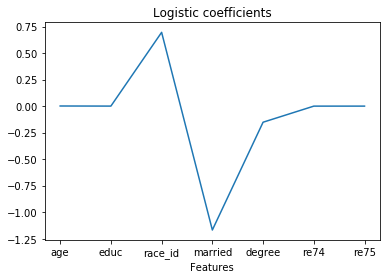

In [32]:
plt.plot(logistic.coef_[0])
plt.title('Logistic coefficients')
plt.xlabel('Features')
plt.xticks(np.arange(X.columns.size), X.columns.tolist())

logistic.coef_[0]

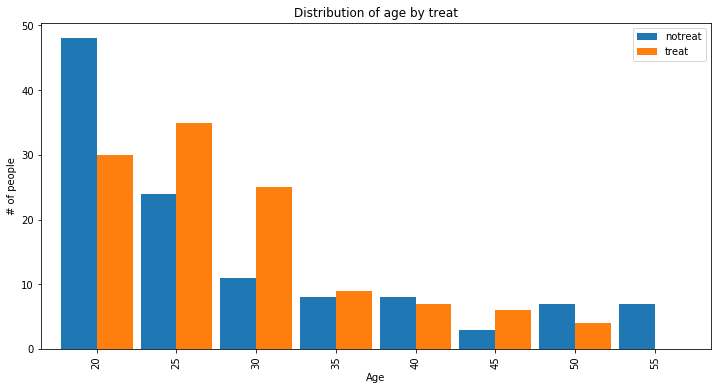

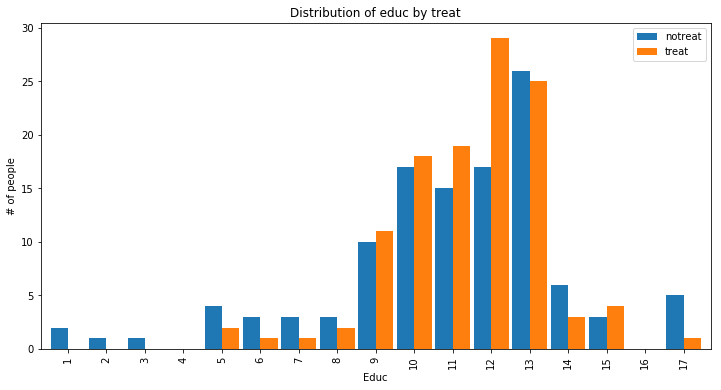

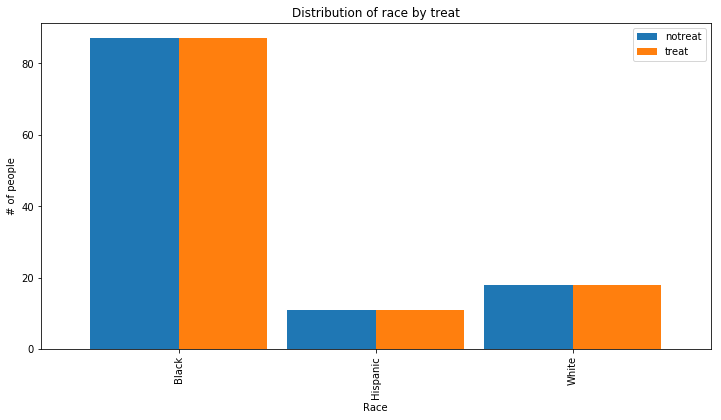

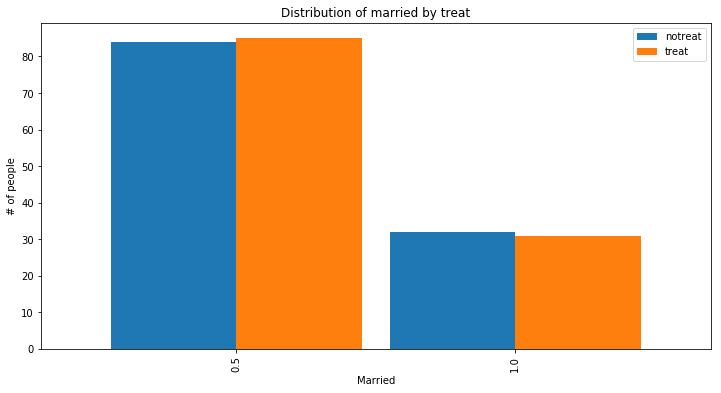

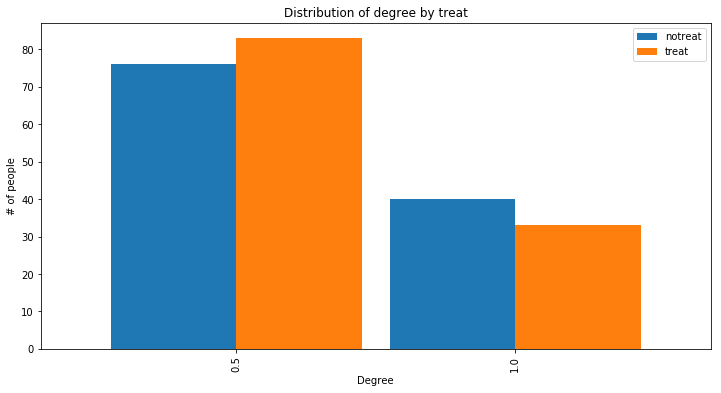

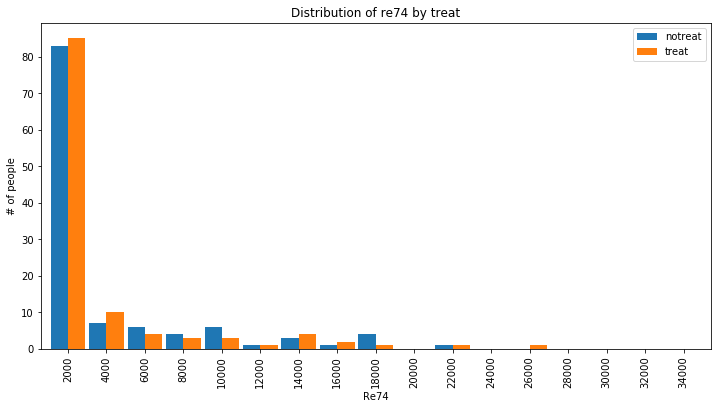

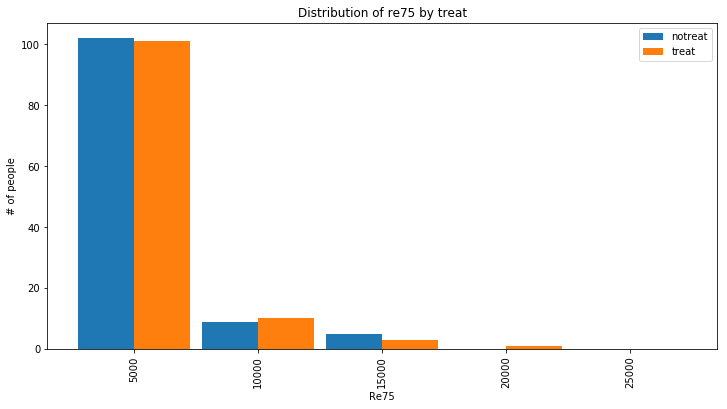

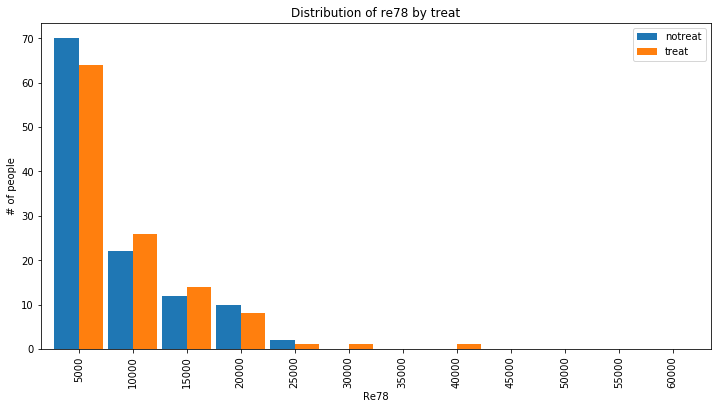

In [44]:
bin_sizes = { 'age': 5, 'educ': 1, 'race': 0.667, 'married': 0.5, 'degree': 0.5, 're74': 2000, 're75': 5000, 're78': 5000 }

for feature in bin_sizes.keys():
    hist_by_treat(balanced_lalonde, feature, bin_sizes[feature])
    plt.title('Distribution of {} by treat'.format(feature))
    plt.xlabel(feature.capitalize())
    plt.ylabel('# of people')

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

#### Answer

The race of the people is an important variable, but it's still too different between the two groups. To get more significant result, we force the people to belong to the same race for the matching.

Now all the important features are balanced between the two groups and we may be able to draw a meaningful conclusion from the data.

In [37]:
import networkx as nx

treat_group = lalonde[lalonde.treat == True]
control_group = lalonde[lalonde.treat == False]

print("Add nodes to graph...")
G = nx.Graph()
G.add_nodes_from(treat_group.index, bipartite = 1)
G.add_nodes_from(control_group.index, bipartite = 0)

print("Add edges to graph...")
for treat_idx, treat in treat_group.iterrows():
    for control_idx, control in control_group.iterrows():
        if treat.race != control.race:
            continue
            
        weight = -abs(treat.propensity - control.propensity)
        G.add_edge(treat_idx, control_idx, weight = weight)

print("Match nodes...")
matches = nx.matching.max_weight_matching(G, maxcardinality = True)

print("Building balanced groups...")
balanced_treat_group = treat_group.loc[matches.keys()].dropna()
balanced_control_group = control_group.loc[matches.keys()].dropna()
balanced_lalonde = balanced_treat_group.append(balanced_control_group)

Add nodes to graph...
Add edges to graph...
Match nodes...
Building balanced groups...


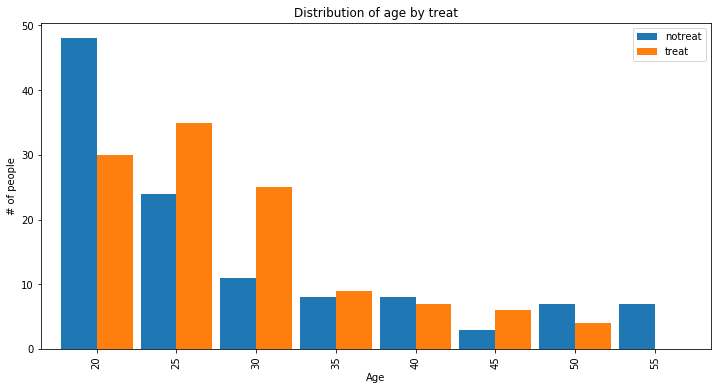

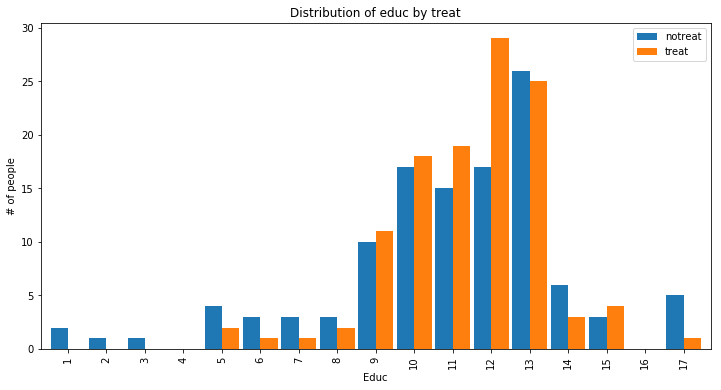

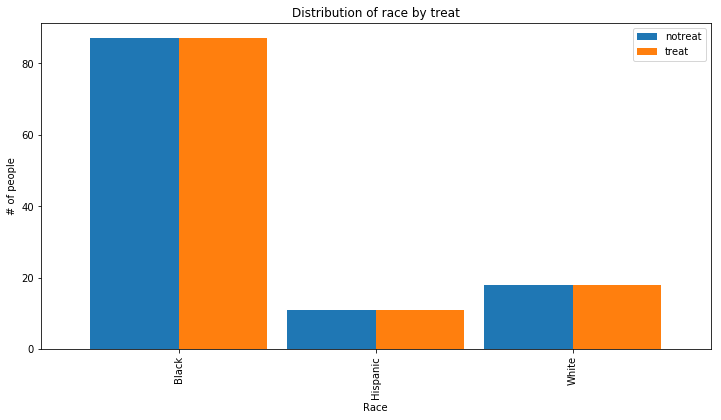

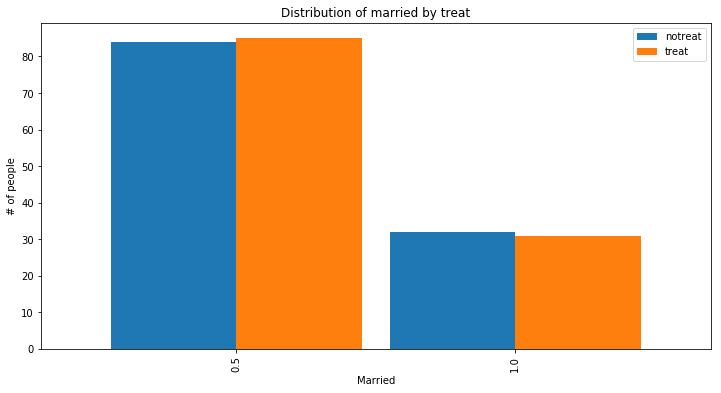

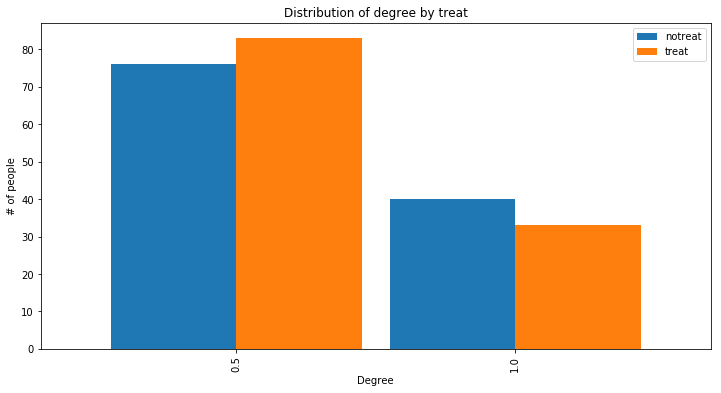

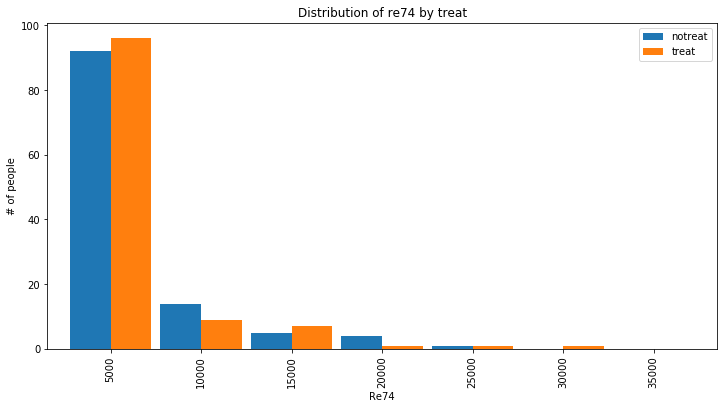

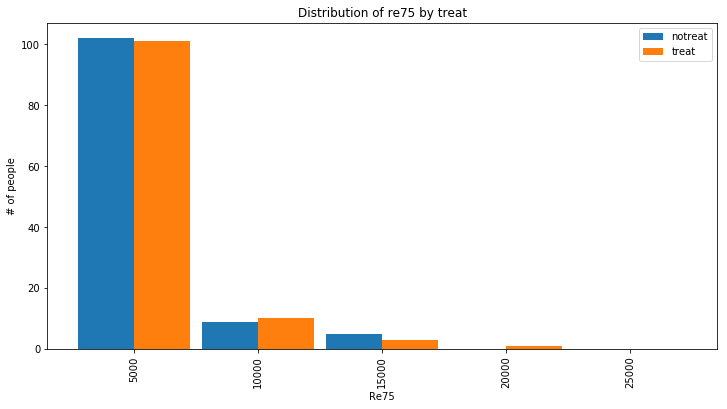

In [45]:
bin_sizes = { 'age': 5, 'educ': 1, 'race': 0.667, 'married': 0.5, 'degree': 0.5, 're74': 5000, 're75': 5000 }

for feature in bin_sizes.keys():
    hist_by_treat(balanced_lalonde, feature, bin_sizes[feature])
    plt.title('Distribution of {} by treat'.format(feature))
    plt.xlabel(feature.capitalize())
    plt.ylabel('# of people')

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

#### Answer

With the non balanced groups, the revenue in 1978 of treated people was always lower than the people in the control group. Now the story is different: we have less people with a revenue `<5000$` in the treated group than in the control group and we have more treated people with revenue in the range between `5000$` and `15,000$`. This shows us that training do help people to improve their revenue!

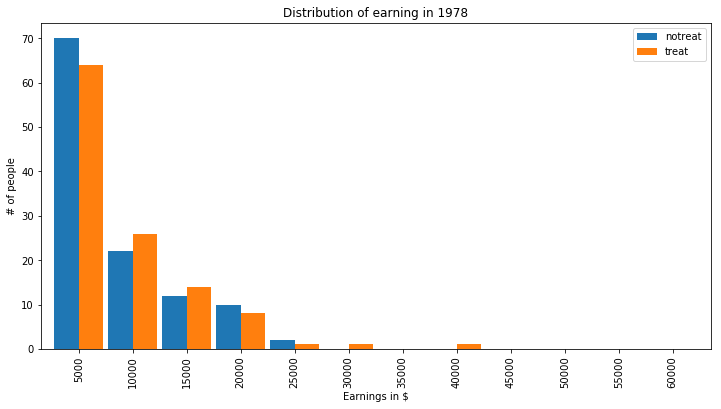

In [46]:
hist_by_treat(balanced_lalonde, 're78', 5000)
plt.title('Distribution of earning in 1978')
plt.xlabel('Earnings in $')
plt.ylabel('# of people')

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.